In [1]:
!ls data/*/*.csv

data/McGill-Billboard/billboard-2.0-index.csv
data/McGill-Billboard/billboard-2.0-manychords-chorddurations.csv
data/McGill-Billboard/billboard-2.0-manychords.csv
data/McGill-Billboard/billboard-2.0-unique.csv


In [2]:
import pandas as pd
df = pd.read_csv('data/McGill-Billboard/billboard-2.0-index.csv')
df.head()

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN


In [29]:
# check date range of songs
years = pd.DatetimeIndex(df.chart_date).year
print(f'{years.min()}-{years.max()}')

1958-1991


In [3]:
# for our application we're only interested in ID, title, and artist
df_songs = df[df.title.notnull() & df.artist.notnull()][['id', 'title', 'artist']]
df_songs.head()

,id,title,artist
2,3,I Don't Mind,James Brown
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
9,10,An Innocent Man,Billy Joel
11,12,Lookin' For Love,Johnny Lee


In [18]:
# check duplicates
dups = df_songs[df_songs.duplicated(subset=['title','artist'], keep=False)]
dups.head()

,id,title,artist
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
15,16,She Bop,Cyndi Lauper
22,23,And She Was,Talking Heads
28,29,The Joker,Steve Miller Band


#### Check available features

In [4]:
base_dir = 'data/McGill-Billboard'
sample_dir = f'{base_dir}/0003'
!ls {sample_dir} -l

total 812
-rw-rw-r-- 1 cjbayron cjbayron 580969 Aug  2  2013 bothchroma.csv
-rw-rw-r-- 1 cjbayron cjbayron 221942 Aug  2  2013 echonest.json
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 full.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin7inv.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin7.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmininv.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin.lab
-rw-rw-r-- 1 cjbayron cjbayron     62 Aug  2  2013 tuning.csv


In [11]:
!cat {sample_dir}/tuning.csv

"/tmp/audio.wav",0.000000000,151.022585034,441.452,"441,5 Hz"


In [26]:
!cat {sample_dir}/majmin7.lab | head -n 5

0.0	7.3469387e-2	N
7.3469387e-2	1.51356009	N
1.51356009	1.8015782305999999	N
1.8015782305999999	3.529687074200001	A:min
3.529687074200001	5.257795917800002	A:min


In [27]:
!cat {sample_dir}/bothchroma.csv | head -n 5

"/tmp/audio.wav",0.000000000,0.198482,0,0,0.635556,0.741292,1.0043,0.81444,0.0292819,0.141189,0.80793,0.91015,0.823603,1.22066,0.0969013,0.197437,0.860228,1.16515,1.13561,0.42842,0.112475,1.49297,0.556156,0.562561,0.864485
,0.046439909,0.310882,0,0,0.693876,0.628553,1.08004,0.676368,0.0175979,0.140079,0.927873,0.663851,0.460197,1.16061,0.306418,0.39068,0.939165,1.05337,1.30823,0.32271,0.0675953,1.53804,0.566076,0.627636,0.904673
,0.092879818,0.404969,0,0.0372381,0.68277,0.59114,1.14683,0.575229,0.0146243,0.128743,0.968012,0.461634,0.260265,1.18625,0.357235,0.392881,0.924133,0.946938,1.36967,0.23419,0.0561735,1.42935,0.532472,0.686886,0.906338
,0.139319727,0.480218,0,0.00500218,0.435639,0.450297,1.21112,0.458671,0.00637153,0.102629,0.962884,0.301896,0.257244,1.08408,0.395586,0.323281,0.917475,0.679013,1.48532,0.186736,0.0244738,1.22717,0.529464,0.717978,1.05768
,0.185759637,0.539064,0.146614,0.0108908,0.444361,0.196939,1.29815,0.239054,0.0233052,0.20809,0.948395,0.0258015,0.341731,0.945

In [47]:
# check if duplicates are exact match
NUM_CHECKS = 5
for ix in dups.index[:NUM_CHECKS]:
    row = dups.loc[ix]
    ids = df_songs[(df_songs.title == row.title)
                   & (df_songs.artist == row.artist)].id.values
    
    ref_id = ids[0]
    dirname = f'{base_dir}/{ref_id:04d}'
    with open(f'{dirname}/tuning.csv', 'r') as f:
        ref_tuning = f.read()
    
    with open(f'{dirname}/majmin7.lab', 'r') as f:
        ref_chords = f.read()
        
    with open(f'{dirname}/bothchroma.csv', 'r') as f:
        ref_chroma = f.read()
    
    for _id in ids[1:]:
        dirname = f'{base_dir}/{_id:04d}'
        with open(f'{dirname}/tuning.csv', 'r') as f:
            tuning = f.read()
        
        with open(f'{dirname}/majmin7.lab', 'r') as f:
            chords = f.read()
        
        with open(f'{dirname}/bothchroma.csv', 'r') as f:
            chroma = f.read()
        
        print(f'{_id:04d} to {ref_id:04d} [tuning]: {ref_tuning == tuning}')
        print(f'{_id:04d} to {ref_id:04d} [chords]: {ref_chords == chords}')
        print(f'{_id:04d} to {ref_id:04d} [chroma]: {ref_chroma == chroma}')
        print()

1229 to 0004 [tuning]: True
1229 to 0004 [chords]: True
1229 to 0004 [chroma]: True

1271 to 0006 [tuning]: True
1271 to 0006 [chords]: True
1271 to 0006 [chroma]: True

1274 to 0016 [tuning]: True
1274 to 0016 [chords]: True
1274 to 0016 [chroma]: True

0870 to 0023 [tuning]: True
0870 to 0023 [chords]: True
0870 to 0023 [chroma]: True

0504 to 0029 [tuning]: True
0504 to 0029 [chords]: True
0504 to 0029 [chroma]: True



This builds the confidence that we can just remove duplicates.

In [5]:
# we remove duplicated songs (except first occurrence)
unique_filter = ~df_songs.duplicated(subset=['title','artist'], keep='first')
df_songs_unique = df_songs[unique_filter]
print(len(df_songs_unique))
df_songs_unique.head()

742


,id,title,artist
2,3,I Don't Mind,James Brown
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
9,10,An Innocent Man,Billy Joel
11,12,Lookin' For Love,Johnny Lee


In [6]:
# check again
any(df_songs_unique.duplicated(subset=['title', 'artist']))

False

In [8]:
df_songs_unique.to_csv(f'{base_dir}/billboard-2.0-unique.csv', index=False)

#### Pick songs for feature analysis

In [3]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

df_songs_unique = pd.read_csv(f'{base_dir}/{data_index}')
df_songs_unique.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [4]:
df_songs_unique.tail()

,id,title,artist
737,1286,Sukiyaki,A Taste Of Honey
738,1287,Johnny Reb,Johnny Horton
739,1289,There She Goes,The La's
740,1290,Happy Together,The Turtles
741,1292,He's So Fine,The Chiffons


In [2]:
df_songs_unique[df_songs_unique.title.str.contains("kiss", case=False)]

,id,title,artist
7,18,Kiss On My List,Daryl Hall & John Oates
31,54,Last Kiss,J. Frank Wilson & The Cavaliers
171,263,Last Kiss,Wednesday
238,370,Kisses On The Wind,Neneh Cherry
302,478,One Last Kiss,The J. Geils Band
511,856,I Like The Way (The Kissing Game),Hi-Five


In [94]:
df_songs_unique.artist.sample(n=10)

124         The O'Jays
436         Commodores
605    Aretha Franklin
621               Dion
270    George Harrison
4           Johnny Lee
493       Bill Withers
338        The Trammps
363              Queen
557             Boston
Name: artist, dtype: object

In [5]:
# after going around the list, picked the following:

# - 1289 - There She Goes - The La's
# - 736 - Do I Do - Stevie Wonder
# - 637 - Human Nature - Michael Jackson
# - 270 - In My Room - The Beach Boys
# - 18 - Kiss On My List - Daryl Hall & John Oates

picked_ids = [1289, 736, 637, 270, 18]

We download these songs to analyse if we can extract chroma features closely similar to those provided by dataset.

In [6]:
# check duration
for _id in picked_ids:
    tuning = f'{base_dir}/{_id:04d}/tuning.csv'
    title = df_songs_unique[df_songs_unique.id == _id].iloc[0].title
    contents = pd.read_csv(tuning, header=None)
    duration = contents[2].iloc[0]
    print(f'{title}: {duration:.2f}s, {int(duration/60)}:{int(duration%60.0):02d}')

There She Goes: 162.54s, 2:42
Do I Do: 629.17s, 10:29
Human Nature: 245.76s, 4:05
In My Room: 134.68s, 2:14
Kiss On My List: 231.27s, 3:51


In [7]:
# convert to wav
from glob import glob
import codecs

for _id in picked_ids:
    mp3_pattern = f'data/audio/{_id:04d}/*.mp3'
    mp3_list = glob(mp3_pattern) + glob(mp3_pattern.replace('mp3','m4a'))
    if len(mp3_list) == 0:
        print(f'{_id}: Missing MP3')
        continue

    mp3_fn = f'"{mp3_list[0]}"'
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    print(mp3_fn, audio_fn)
    
    !ffmpeg -y -i {mp3_fn} {audio_fn}

"data/audio/1289/09 There She Goes.m4a" data/audio/1289/audio.wav
ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --e

size=  108200kB time=00:10:28.14 bitrate=1411.1kbits/s    
video:0kB audio:108200kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000305%
"data/audio/0637/07 Human Nature.m4a" data/audio/0637/audio.wav
ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libop

size=   23080kB time=00:02:14.02 bitrate=1410.7kbits/s    
video:0kB audio:23080kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001219%
"data/audio/0018/06 Kiss On My List.m4a" data/audio/0018/audio.wav
ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-lib

#### Chroma feature analysis

In [8]:
def load_billboard_chroma(_id):
    """ Load bothchroma(bass-treble) vectors from Billboard dataset """
    
    fn = f'{base_dir}/{_id:04d}/bothchroma.csv'
    contents = pd.read_csv(fn, header=None)
    
    # we only get 3rd column onwards
    # (first column empty, 2nd column time tick)
    bothchroma = contents[contents.columns[2:]].values
    return bothchroma
    
# chroma_samp = load_billboard_chroma(1289)
# chroma_samp.shape

In [9]:
from scipy.signal import resample
import librosa
import vamp
import torch
from torchaudio.transforms import Resample

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
_SAMPLE_RATE = 44100
def generate_chroma(_id, resampler='scipy', params={}):
    """ Generate chroma from raw audio """
    
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        if resampler == 'scipy':
            X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
        elif resampler == 'torch':
            resampling_transform = Resample(orig_freq=fs,
                                            new_freq=_SAMPLE_RATE)
            X = resampling_transform(torch.Tensor([X])).squeeze().numpy()
        else:
            raise Exception('unsupported resampler')
    
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    chroma = out['matrix'][1]
    return chroma

# chroma_gen = generate_chroma(1289)
# chroma_gen.shape

# chroma_gen = generate_chroma(1289, resampler='torch')
# chroma_gen.shape

In [12]:
picked_ids.sort()
picked_ids

[18, 270, 637, 736, 1289]

In [63]:
def normalize_chroma(chroma):
    return (chroma / (chroma.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps))

In [69]:
from librosa.sequence import dtw

def compare_chroma(picked_ids, normalize=True):
    print('**Feature comparison scores: (lower, better)**')
    print(picked_ids)
    for ix, _id in enumerate(picked_ids):
        #_, fs = librosa.load(audio_fn, sr=None, mono=True)
        #print(f'{df_songs_unique[df_songs_unique.id == _id].iloc[0].title} ({fs} Hz)')
        chroma_samp = load_billboard_chroma(_id)
        if normalize:
            chroma_samp = normalize_chroma(chroma_samp)

    #     if ix == 0:
    #         ref_id = picked_ids[-1]
    #     else:
    #         ref_id = picked_ids[ix-1]

        print(f'{_id} : ', end='')
        for ref_id in picked_ids:
            chroma_gen = generate_chroma(ref_id, params={'rollon': 1.0})
            if normalize:
                chroma_gen = normalize_chroma(chroma_gen)

            D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
            #print(f'- baseline {_id} vs. {ref_id}: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')
            #print(f'{D[-1,-1]:.2f}/{len(wp)} ({(D[-1,-1]/len(wp)):.4f}) | ', end='')
            print(f'{(D[-1,-1]/len(wp)):.4f} | ', end='')

    #     chroma_gen = generate_chroma(_id)
    #     D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    #     print(f'- default params: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')

    #     chroma_gen = generate_chroma(_id, params={'rollon': 1.0})
    #     D, wp = dtw(chroma_samp.T, chroma_samp.T, subseq=True)
    #     print(f'- rollon=1.0: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')

    #     chroma_gen = generate_chroma(_id, resampler='torch')
    #     D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    #     print(f'- (torch) default params: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')

    #     chroma_gen = generate_chroma(_id, resampler='torch', params={'rollon': 1.0})
    #     D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    #     print(f'- (torch) rollon=1.0: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')
        print('')

In [70]:
print('------------')
compare_chroma(picked_ids, normalize=True)
print('------------')
compare_chroma(picked_ids, normalize=False)

------------
**Feature comparison scores: (lower, better)**
[18, 270, 637, 736, 1289]
18 : 0.0803 | 0.3684 | 0.2799 | 0.2650 | 0.2639 | 
270 : 0.3656 | 0.0418 | 0.3344 | 0.2832 | 0.3422 | 
637 : 0.2802 | 0.3381 | 0.0312 | 0.3003 | 0.2782 | 
736 : 0.2674 | 0.2804 | 0.2997 | 0.0478 | 0.2810 | 
1289 : 0.2599 | 0.3445 | 0.2741 | 0.2904 | 0.0385 | 
------------
**Feature comparison scores: (lower, better)**
[18, 270, 637, 736, 1289]
18 : 1.0653 | 4.4305 | 3.8831 | 3.5445 | 3.5348 | 
270 : 4.4804 | 0.5193 | 3.9131 | 3.3354 | 4.4072 | 
637 : 3.8986 | 4.0635 | 0.3681 | 3.5872 | 3.6627 | 
736 : 3.4894 | 3.2144 | 3.6010 | 0.5766 | 3.7130 | 
1289 : 3.4910 | 4.2692 | 3.6262 | 3.8185 | 0.5162 | 


#### Prep for loading the data

In [1]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

In [2]:
df_songs = pd.read_csv(f'{base_dir}/{data_index}')
df_songs.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [3]:
len(df_songs)

742

In [8]:
!ls {base_dir}/1289

bothchroma.csv	full.lab	majmin7.lab    majmin.lab
echonest.json	majmin7inv.lab	majmininv.lab  tuning.csv


In [11]:
!tail {base_dir}/1289/bothchroma.csv

,161.982403628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.028843537,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.075283446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.121723356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.168163265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.214603174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.261043083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.307482993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.353922902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.400362811,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
def get_chroma_matrix(_id, return_timestamps=False):
    """ Load bothchroma(bass-treble) vectors from Billboard dataset """
    
    fn = f'{base_dir}/{_id:04d}/bothchroma.csv'
    contents = pd.read_csv(fn, header=None)
    
    # we only get 3rd column onwards
    # (first column empty, 2nd column time tick)
    bothchroma = contents[contents.columns[2:]].values
    if not return_timestamps:
        return bothchroma
    
    start_times = contents[contents.columns[1]].values
    step_size = start_times[1]
    end_times = np.append(start_times[1:], [start_times[-1]+step_size], axis=0)
    timestamps = np.vstack((start_times, end_times)).T
    return timestamps, bothchroma

In [33]:
get_chroma_matrix(1289).shape # num frames, chroma feature size

(3498, 24)

In [34]:
ts, cmatrix = get_chroma_matrix(1289, return_timestamps=True)
print(ts.shape, cmatrix.shape)

(3498, 2) (3498, 24)


#### Feature description

From reading bothchroma and chroma feature comparison:

- sample rate: **44100 Hz**
- step size for **each** chroma vector: 0.046439909s or **~50ms**
    - equivalent to 0.046439909 * 44100 = **~2048 samples**
- 64 chroma vectors ~= 3s
- 128 chroma vectors ~= 6s

In [11]:
lab_fn = f'{base_dir}/1289/majmin.lab'
!head {lab_fn}

0.0	0.325079365	N
0.325079365	1.3641723354999997	G:maj
1.3641723355000002	2.4032653059999998	D:maj
2.4032653060000007	4.481451247000001	C:maj
4.481451247000002	5.520544217500001	G:maj
5.520544217500002	6.559637188000002	D:maj
6.559637188000003	8.118276643750002	C:maj
8.118276643750004	8.637823129000003	D:maj
8.637823129	9.634569160749999	G:maj
9.634569160749999	10.631315192499999	D:maj


In [4]:
import mir_eval

def get_chord_labels(_id, label_type='majmin'):
    """ Load chord labels from .LAB files
    
    label_type: majmin, majmin7, majmininv, majmin7inv, full
    """
    lab_fn = f'{base_dir}/{_id:04d}/{label_type}.lab'
    # any line starting w/ \n is ignored e.g. blank lines
    timestamps, chord_labels = mir_eval.io.load_labeled_intervals(lab_fn, comment='\n')
    return timestamps, chord_labels

In [5]:
timestamps, chord_labels = get_chord_labels(1289)
for ix, (ts, lab) in enumerate(zip(timestamps, chord_labels)):
    print(ts, lab)
    if ix == 5:
        break

[0.         0.32507937] N
[0.32507937 1.36417234] G:maj
[1.36417234 2.40326531] D:maj
[2.40326531 4.48145125] C:maj
[4.48145125 5.52054422] G:maj
[5.52054422 6.55963719] D:maj


Now we have to map EACH chroma vector to these labels.

Considerations:
* *Time steps of vectors does not match time steps in labels* - for first iteration, we can **ignore** chroma vectors spanning multiple labels / occuring at chord transitions
* *Numerical representation of chords* - `mir_eval.chords.encode()` converts chord labels to (semitone, quality (maj,min,etc.); for first iteration, we **limit to majmin and "squash" both semitone and quality in a single label**. We also **add 1** to the representation to shift -1 encoding for N (no chord) to 0

Before we perform actual encoding of labels, let's perform some checks first.

In [83]:
from tqdm import tqdm

majmin_chordset = set()
majmin7_chordset = set()

for _id in tqdm(df_songs.id):
    _, chord_labels = get_chord_labels(_id, label_type='majmin')
    majmin_chordset.update(chord_labels)
    
    _, chord_labels = get_chord_labels(_id, label_type='majmin7')
    majmin7_chordset.update(chord_labels)

100%|██████████| 742/742 [00:00<00:00, 809.76it/s]


In [93]:
temp = list(majmin_chordset)
temp.sort()
print(temp)

['A#:maj', 'A:maj', 'A:min', 'Ab:maj', 'Ab:min', 'B:maj', 'B:min', 'Bb:maj', 'Bb:min', 'C#:maj', 'C#:min', 'C:maj', 'C:min', 'Cb:maj', 'Cb:min', 'D#:maj', 'D#:min', 'D:maj', 'D:min', 'Db:maj', 'Db:min', 'E:maj', 'E:min', 'Eb:maj', 'Eb:min', 'F#:maj', 'F#:min', 'F:maj', 'F:min', 'Fb:maj', 'G#:maj', 'G#:min', 'G:maj', 'G:min', 'Gb:maj', 'Gb:min', 'N', 'X']


In [94]:
temp = list(majmin7_chordset)
temp.sort()
print(temp)

['A#:maj', 'A:7', 'A:maj', 'A:maj7', 'A:min', 'A:min7', 'Ab:7', 'Ab:maj', 'Ab:maj7', 'Ab:min', 'Ab:min7', 'B:7', 'B:maj', 'B:maj7', 'B:min', 'B:min7', 'Bb:7', 'Bb:maj', 'Bb:maj7', 'Bb:min', 'Bb:min7', 'C#:7', 'C#:maj', 'C#:min', 'C#:min7', 'C:7', 'C:maj', 'C:maj7', 'C:min', 'C:min7', 'Cb:7', 'Cb:maj', 'Cb:maj7', 'Cb:min', 'D#:7', 'D#:maj', 'D#:min', 'D#:min7', 'D:7', 'D:maj', 'D:maj7', 'D:min', 'D:min7', 'Db:7', 'Db:maj', 'Db:maj7', 'Db:min', 'Db:min7', 'E:7', 'E:maj', 'E:maj7', 'E:min', 'E:min7', 'Eb:7', 'Eb:maj', 'Eb:maj7', 'Eb:min', 'Eb:min7', 'F#:7', 'F#:maj', 'F#:min', 'F#:min7', 'F:7', 'F:maj', 'F:maj7', 'F:min', 'F:min7', 'Fb:maj', 'Fb:maj7', 'G#:7', 'G#:maj', 'G#:min', 'G#:min7', 'G:7', 'G:maj', 'G:maj7', 'G:min', 'G:min7', 'Gb:7', 'Gb:maj', 'Gb:maj7', 'Gb:min', 'Gb:min7', 'N', 'X']


Looks good. We can interpret X and N as same class.

In [113]:
for _id in tqdm(df_songs.id):
    ts, _ = get_chord_labels(_id)
    # check if intervals are contiguous
    assert(sum(ts[:-1, 1] - ts[1:, 0]) < 1e-9)
    # check if time values are all positive
    assert((ts >= 0.0).all())

100%|██████████| 742/742 [00:00<00:00, 1556.25it/s]


Looks good. We now proceed to encoding the labels.

In [5]:
import numpy as np

# bitmaps of chord qualities
_MAJ_BITMAP = mir_eval.chord.quality_to_bitmap('maj')
_MIN_BITMAP = mir_eval.chord.quality_to_bitmap('min')
_MAJ7_BITMAP = mir_eval.chord.quality_to_bitmap('maj7')
_MIN7_BITMAP = mir_eval.chord.quality_to_bitmap('min7')

_NUM_SEMITONE = 12

def encode_chords_single_label(chord_labels):
    """ Encode chord labels to a single label (semitone/root, quality in one) """
    
    # third array is bass number, which we ignore
    root_classes, quality_classes, _ = mir_eval.chord.encode_many(chord_labels)
    root_classes += 1 # add 1 to shift No Chord (-1) to 0

    min_chords_filt = np.all(quality_classes == _MIN_BITMAP, axis=1)
    maj7_chords_filt = np.all(quality_classes == _MAJ7_BITMAP, axis=1)
    min7_chords_filt = np.all(quality_classes == _MIN7_BITMAP, axis=1)

    root_classes[min_chords_filt] += _NUM_SEMITONE
    root_classes[maj7_chords_filt] += _NUM_SEMITONE*2
    root_classes[min7_chords_filt] += _NUM_SEMITONE*3

    return root_classes

chord_classes = encode_chords_single_label(get_chord_labels(1289)[1])
chord_classes[:5]

array([0, 8, 3, 1, 8])

In [140]:
# similar check from last time; this time the encodings are checked
from tqdm import tqdm

majmin_chordset = set()
majmin7_chordset = set()

for _id in tqdm(df_songs.id):
    _, chord_labels = get_chord_labels(_id, label_type='majmin')
    majmin_chordset.update(encode_chords_single_label(chord_labels))
    
    _, chord_labels = get_chord_labels(_id, label_type='majmin7')
    majmin7_chordset.update(encode_chords_single_label(chord_labels))

100%|██████████| 742/742 [00:01<00:00, 547.63it/s]


In [141]:
temp = list(majmin_chordset)
temp.sort()
print(temp)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [142]:
temp = list(majmin7_chordset)
temp.sort()
print(temp)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


Looks great! We can proceed to matching the chroma vectors and these labels for model training.

In [6]:
import numpy as np

def get_chord_features_and_labels(_id):
    """ Get chroma vectors and chord labels """
    chroma_timestamps, chroma_vectors = get_chroma_matrix(_id, return_timestamps=True)
    chord_timestamps, chord_labels_str = get_chord_labels(_id)
    chord_labels = encode_chords_single_label(chord_labels_str)

    assert(len(chroma_timestamps) == len(chroma_vectors))
    assert(len(chord_timestamps) == len(chord_labels))

    # label for each chroma vector
    chromavec_labels = np.zeros(len(chroma_vectors)).astype(np.int)-1 # all -1's
    st_ix = 0 # lower bound for updating labels
    for i, (ts, chord_label) in enumerate(zip(chord_timestamps, chord_labels)):
        # get indices of chroma timestamps within duration of current chord
        in_cur_chord = (chroma_timestamps[st_ix:, 0] >= ts[0]) \
                        & (chroma_timestamps[st_ix:, 1] <= ts[1])
        chromavec_labels[st_ix:][in_cur_chord] = chord_label

        # update lower bound
        in_cur_chord = in_cur_chord.astype(int)
        transitions = in_cur_chord[1:] - in_cur_chord[:-1]
        # we get index of first occurence of True->False transition
        # False-True = -1
        TtoF_ixs = np.where(transitions==-1)[0]

        if len(TtoF_ixs) > 0:
            st_ix += (TtoF_ixs[0] + 1) # +1 due to offset by diffing to get transitions

    remove_ambiguous_mask = (chromavec_labels != -1)
    return chroma_vectors[remove_ambiguous_mask], chromavec_labels[remove_ambiguous_mask]

In [7]:
chroma_vectors, chord_labels = get_chord_features_and_labels(1289)

In [9]:
chroma_vectors.shape, chord_labels.shape

((3358, 24), (3358,))

In [157]:
chord_labels[:100]

array([0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8])

Now we use the feature & label extraction function on all data. (Try if we can fit all of it into memory i.e. a single NumPy array).

In [26]:
len(df_songs), chroma_vectors.nbytes, chord_labels.nbytes

(742, 644736, 26864)

In [27]:
print(f'estimate memory size: {(len(df_songs)*(chroma_vectors.nbytes+chord_labels.nbytes)/(1024*1024)):.2f} MB')

estimate memory size: 475.24 MB


In [36]:
from tqdm import tqdm

all_chroma_vectors = []
all_chord_labels = []

for _id in tqdm(df_songs.id):
    chroma_vectors, chord_labels = get_chord_features_and_labels(_id)
    
    if len(all_chroma_vectors) == 0:
        all_chroma_vectors = chroma_vectors
        all_chord_labels = chord_labels
    else:    
        all_chroma_vectors = np.concatenate((all_chroma_vectors, chroma_vectors))
        all_chord_labels = np.concatenate((all_chord_labels, chord_labels))

 77%|███████▋  | 569/742 [00:59<00:30,  5.63it/s]/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/mir_eval/io.py:281: UserWarning: All interval durations must be strictly positive
  warnings.warn(error.args[0])
100%|██████████| 742/742 [01:33<00:00,  7.93it/s]


In [ ]:
# check 569?

In [39]:
print(f'actual memory size: {((all_chroma_vectors.nbytes+all_chord_labels.nbytes)/(1024*1024)):.2f} MB')

actual memory size: 640.97 MB


In [40]:
np.save('data/01_all_chroma_vectors.npy', all_chroma_vectors)
np.save('data/01_all_chord_labels.npy', all_chord_labels)

In [41]:
all_chroma_vectors.shape, all_chord_labels.shape

((3360513, 24), (3360513,))

With this data, we can proceed to first training iteration.

#### Feature check

In [1]:
import numpy as np
from scipy.signal import resample
import librosa
import vamp

_SAMPLE_RATE = 44100
def generate_chroma_from_wav(audio_fn, params={'rollon': 1.0}):
    """ Generate chroma from raw audio """
    
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
        
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    
    chroma = out['matrix'][1]
    return chroma

(151, 24)


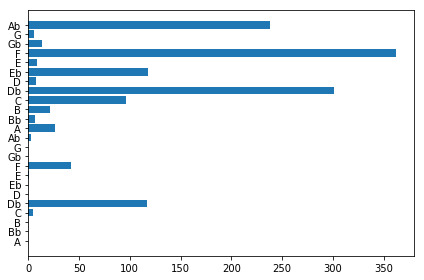

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#notes = ['C','Db','D','Eb','E','F','Gb','G','Ab','A','Bb','B'] # this is WRONG!!!!
notes = ['A','Bb','B', 'C','Db','D','Eb','E','F','Gb','G','Ab']
cmx = generate_chroma_from_wav('data/freesound/c_major.wav')
print(cmx.shape)
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

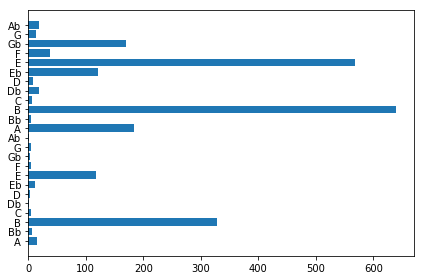

In [27]:
cmx = generate_chroma_from_wav('data/freesound/a_major.wav')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

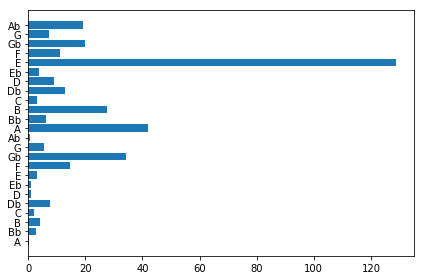

In [28]:
cmx = generate_chroma_from_wav('data/freesound/e4.wav')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


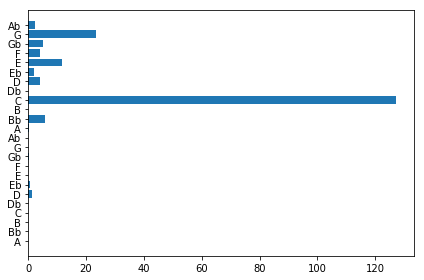

In [29]:
cmx = generate_chroma_from_wav('data/freesound/c.m4a')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


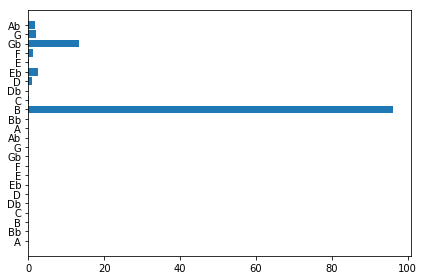

In [30]:
cmx = generate_chroma_from_wav('data/freesound/b.m4a')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

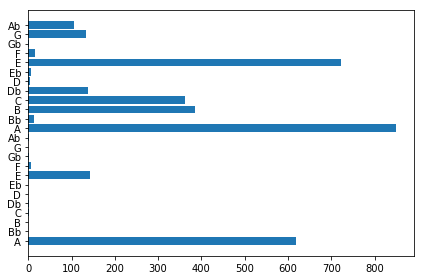

In [31]:
cmx = generate_chroma_from_wav('data/freesound/a_minor.wav')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

Realizations from here:
- Chordino bothchroma is intepreted as: [0:12], [12:24] -> [A up to Ab], bass, treble
- Chordino output can have "incorrect" chroma values (perhaps due to tuning issues...) e.g. C maj interpreted as Dbmaj
    - BUT, the quality of the chord is retained
    - Also try to visualize each individual vector (instead of only mean/sum) to confirm

In [3]:
# try on a larger scale
all_chroma_vectors = np.load('data/01_all_chroma_vectors.npy')
all_chord_labels = np.load('data/01_all_chord_labels.npy')
all_chroma_vectors.shape, all_chord_labels.shape

((3360513, 24), (3360513,))

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


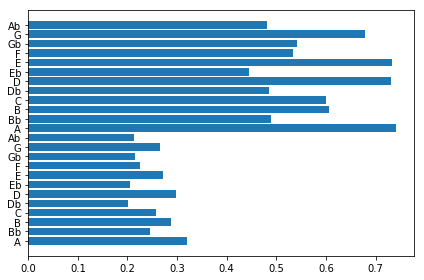

In [4]:
filt = [all_chord_labels == 0] # no chord
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


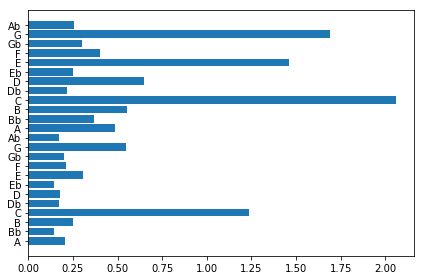

In [5]:
filt = [all_chord_labels == 1] # c maj
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


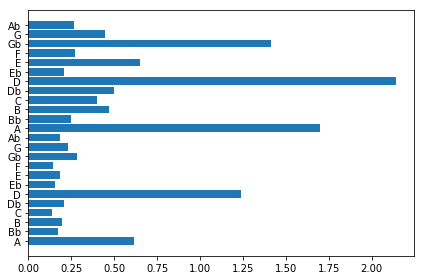

In [7]:
filt = [all_chord_labels == 3] # d maj
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


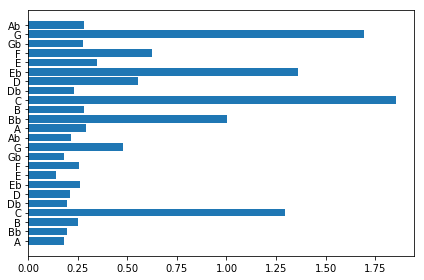

In [39]:
filt = [all_chord_labels == 13] # c min
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

Here we can see that the SUM of the vectors for each class "activate" appropriately at the chord class's pitch classes.

In [6]:
# automated check

import mir_eval

def encode_to_chordino_chroma(label):
    root, quality_map, _ = mir_eval.chord.encode(label)
    root = (root+3)%12 # add 3 to map to chordino chroma
    chord_bitmap = mir_eval.chord.rotate_bitmap_to_root(quality_map, root) 
    return root, chord_bitmap
    
encode_to_chordino_chroma('A:maj')

(0, array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]))

In [10]:
# from importlib import reload
# import dataloader
# reload(dataloader)

from dataloader import _CHROMA_FEAT_NAMES, _MAJMIN_CLASSES

for class_index, chord_name in enumerate(_MAJMIN_CLASSES):
    if class_index == 0:
        continue
    
    root, chord_bitmap = encode_to_chordino_chroma(chord_name)
    filt = (all_chord_labels == class_index)
    vector_mean = np.mean(all_chroma_vectors[filt], axis=0)
    
    vector_topk = set(np.argpartition(vector_mean[12:], -3)[-3:])
    bitmap_topk = set(np.argpartition(chord_bitmap, -3)[-3:])
    
    bass_match = (root == np.argmax(vector_mean[:12]))
    chord_match = (vector_topk == bitmap_topk)
    if (not bass_match) or (not chord_match):
        print(f'{chord_name} - Bass match: {bass_match} - '
              f'Chord match: {chord_match}')

In [9]:
# now check individual vectors

# N.B. add to lazycats
import numpy as np
def top_k_indices(arr, k, axis=1):
    if axis != 1:
        raise NotImplementedError
    
    temp = np.array(arr) # copy
    top_k_ixs = []
    for _ in range(k): # no checking if k > (array length along axis of argmax)
        max_ixs = np.argmax(temp, axis=axis)
        top_k_ixs.append(max_ixs)
        temp[(range(len(temp)), max_ixs)] = -np.inf # remove from next comparison
    
    top_k_ixs = np.hstack([np.array([ixs]).T for ixs in top_k_ixs])
    return top_k_ixs

In [11]:
from collections import Counter
for class_index, chord_name in enumerate(_MAJMIN_CLASSES):
    if class_index == 0:
        continue
    
    root, chord_bitmap = encode_to_chordino_chroma(chord_name)
    filt = (all_chord_labels == class_index)
    
    vecs = all_chroma_vectors[filt]
    bass_vecs = vecs[:, :12]
    treble_vecs = vecs[:, 12:]
    # remove all zeros for comparison
    bass_vecs = bass_vecs[~np.all(bass_vecs <= 0.01, axis=1)]
    treble_vecs = treble_vecs[~np.all(treble_vecs <= 0.01, axis=1)]
    
    basses = np.argmax(bass_vecs, axis=1)
    bass_match = np.mean(basses == root)*100
    ext_bass_match = bass_match + np.mean(basses == (root-1)%12)*100
    ext_bass_match += np.mean(basses == (root+1)%12)*100
    
    
    # get only on treble
    vec_ixs = top_k_indices(treble_vecs, 4, axis=1)
    label_ixs = np.where(chord_bitmap)[0]
    chord_match = np.mean(np.all(np.isin(vec_ixs[:, :3], label_ixs), axis=1))
    ext_match = np.mean((np.sum(np.isin(vec_ixs, label_ixs), axis=1))==3) # ext chord
    
    print(f'{chord_name} - Bass match: {bass_match:.2f} - Ext bass match: {ext_bass_match:.2f} - '
          f'Chord match: {chord_match:.2f} - Ext match: {ext_match:.2f}')
    #print(Counter(basses))

C:maj - Bass match: 54.15 - Ext bass match: 59.47 - Chord match: 0.40 - Ext match: 0.57
Db:maj - Bass match: 50.44 - Ext bass match: 57.59 - Chord match: 0.36 - Ext match: 0.54
D:maj - Bass match: 52.68 - Ext bass match: 57.39 - Chord match: 0.39 - Ext match: 0.57
Eb:maj - Bass match: 50.76 - Ext bass match: 57.84 - Chord match: 0.31 - Ext match: 0.48
E:maj - Bass match: 55.61 - Ext bass match: 60.40 - Chord match: 0.40 - Ext match: 0.57
F:maj - Bass match: 49.97 - Ext bass match: 56.32 - Chord match: 0.37 - Ext match: 0.54
Gb:maj - Bass match: 54.10 - Ext bass match: 60.30 - Chord match: 0.34 - Ext match: 0.52
G:maj - Bass match: 57.03 - Ext bass match: 62.27 - Chord match: 0.39 - Ext match: 0.56
Ab:maj - Bass match: 56.58 - Ext bass match: 63.25 - Chord match: 0.34 - Ext match: 0.52
A:maj - Bass match: 55.39 - Ext bass match: 60.37 - Chord match: 0.36 - Ext match: 0.53
Bb:maj - Bass match: 54.18 - Ext bass match: 61.84 - Chord match: 0.39 - Ext match: 0.56
B:maj - Bass match: 55.60 -

Either there is a lot of mislabels or our features aren't very rich.

#### Exploring tuning

In [4]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

In [5]:
df_songs = pd.read_csv(f'{base_dir}/{data_index}')
df_songs.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [7]:
def get_tuning(_id):
    """ Load tuning data from Billboard dataset """
    
    fn = f'{base_dir}/{_id:04d}/tuning.csv'
    contents = pd.read_csv(fn, header=None)
    
    return contents

get_tuning(1289)

,0,1,2,3,4
0,/tmp/audio.wav,0.0,162.539683,440.082,"440,1 Hz"


In [10]:
from tqdm import tqdm

tunings_len = []
for _id in tqdm(df_songs.id):
    tuning_data = get_tuning(_id)
    tunings_len.append(len(tuning_data.loc[0]))
    tuning_vals

100%|██████████| 742/742 [00:01<00:00, 521.60it/s]


In [11]:
from collections import Counter
Counter(tunings_len)
# ALL tunings file are 1 line, with 5 values

Counter({5: 742})

In [22]:
tuning_data

,0,1,2,3,4
0,/tmp/audio.wav,0.0,115.728254,438.049,"438,0 Hz"


In [23]:
from scipy.signal import resample
import librosa
import vamp

_SAMPLE_RATE = 44100
def generate_tuning(_id, params={}):
    """ Generate chroma from raw audio """
    
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
    
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:tuning',
                       output='tuning', parameters=params)
    return out

generate_tuning(1289, {'rollon':1.0})

{'list': [{'timestamp':  0.000000000,
   'duration':  162.353922902,
   'label': '440.1 Hz',
   'values': array([440.1019], dtype=float32)}]}

In [6]:
# https://github.com/librosa/librosa/blob/main/examples/adjust_tuning.py
def adjust_tuning(y, sr):
    '''Load audio, estimate tuning, apply pitch correction, and save.'''
    y_harm = librosa.effects.harmonic(y)

    print('Estimating tuning ... ')
    # Just track the pitches associated with high magnitude
    tuning = librosa.estimate_tuning(y=y_harm, sr=sr)

    print('{:+0.2f} cents'.format(100 * tuning))
    print('Applying pitch-correction of {:+0.2f} cents'.format(-100 * tuning))
    y_tuned = librosa.effects.pitch_shift(y, sr, -tuning)

    return y_tuned

In [7]:
def generate_tuning_from_wav(audio_fn, params={}, correct_tuning=False):
    """ Generate chroma from raw audio """
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
    if correct_tuning:
        X = adjust_tuning(X, _SAMPLE_RATE)
    
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:tuning',
                       output='tuning', parameters=params)
    return out

In [8]:
generate_tuning_from_wav('data/freesound/c_major.wav', params={'rollon':1.0}, correct_tuning=True)

Estimating tuning ... 
-44.00 cents
Applying pitch-correction of +44.00 cents


{'list': [{'timestamp':  0.000000000,
   'duration':  7.058866213,
   'label': '439.3 Hz',
   'values': array([439.32288], dtype=float32)}]}

In [9]:
def generate_chroma_from_wav(audio_fn, params={'rollon': 1.0}, correct_tuning=False):
    """ Generate chroma from raw audio """
    
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
    if correct_tuning:
        X = adjust_tuning(X, _SAMPLE_RATE)        
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    
    chroma = out['matrix'][1]
    return chroma

(151, 24)


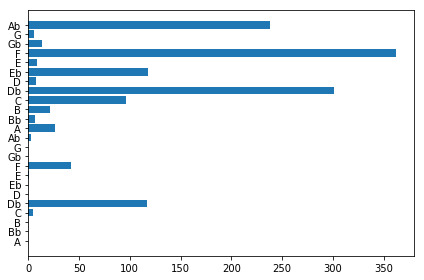

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

notes = ['A','Bb','B', 'C','Db','D','Eb','E','F','Gb','G','Ab']
cmx = generate_chroma_from_wav('data/freesound/c_major.wav', correct_tuning=False)
print(cmx.shape)
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

Estimating tuning ... 
-44.00 cents
Applying pitch-correction of +44.00 cents
(151, 24)


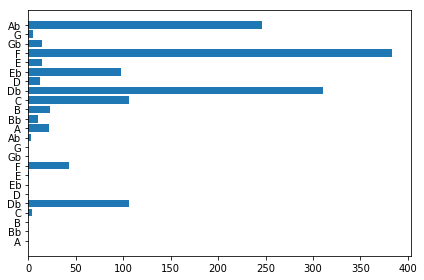

In [34]:
cmx = generate_chroma_from_wav('data/freesound/c_major.wav', correct_tuning=True)
print(cmx.shape)
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

In [ ]:
# tuning doesn't seem to do much

#### Exploring temporal-based features

In [3]:
import dataloader
#from importlib import reload
#reload(dataloader)

chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(1289, label_type='majmin')
chroma_vectors.shape, chord_labels.shape

((3358, 24), (3358,))

In [4]:
# how often do chords change?
arr = chord_labels[:100]
arr

array([0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8])

In [5]:
import numpy as np

# N.B. lazycats entry # 2
def contiguous_lengths(arr):
    assert(len(arr.shape) == 1)
    change_points = np.where(arr[1:]-arr[:-1])[0] + 1 # find where values change
    if len(arr) not in change_points:
        change_points = np.append(change_points, len(arr))

    # compute change point relative to previous change point; this essentially computes
    # the length before the value changes
    return np.concatenate(([change_points[0]], change_points[1:]-change_points[:-1]))

contiguous_lengths(arr)

array([ 7, 22, 21, 44,  6])

In [61]:
# compute for all songs
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

df_songs = pd.read_csv(f'{base_dir}/{data_index}')
df_songs.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [62]:
# before we proceed, let's check first if there are songs that are predominantly no-chords / X-chords

df_songs['no_chord_percent'] = 0
for ix in tqdm(df_songs.index):
    _id = df_songs.loc[ix].id
    chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(_id, label_type='majmin')
    df_songs.loc[ix, 'no_chord_percent'] = np.mean(chord_labels == 0)

100%|██████████| 742/742 [00:19<00:00, 39.04it/s]


In [63]:
threshold = 0.5
print(sum(df_songs.no_chord_percent >= threshold))
df_songs[df_songs.no_chord_percent >= threshold][['id','title','artist','no_chord_percent']].head()

23


,id,title,artist,no_chord_percent
29,51,Carrie,Cliff Richard,0.556433
64,105,The Spirit Of Radio,Rush,0.522856
136,215,Magic Man,Heart,0.695621
138,217,Jessie's Girl,Rick Springfield,0.526966
227,353,I Can't Drive 55,Sammy Hagar,1.000000


For now, let's ignore songs with 50% or more no-chord/X labels.

In [64]:
df_songs = df_songs[~(df_songs.no_chord_percent >= threshold)]
df_songs.to_csv(f'{base_dir}/billboard-2.0-manychords.csv', index=False)

In [65]:
len(df_songs)

719

In [6]:
# lazycats #3
def squash_consecutive_duplicates(arr):
    assert(len(arr.shape) == 1)
    # find where values change
    # this is the first index of any consecutive sequence of same values (except element 0)
    change_points = np.where(arr[1:]-arr[:-1])[0] + 1
    return np.concatenate((arr[0:1], arr[change_points]))

assert(len(squash_consecutive_duplicates(chord_labels))==len(contiguous_lengths(chord_labels)))
squash_consecutive_duplicates(chord_labels)

array([ 0,  8,  3,  1,  8,  3,  1,  3,  8,  3,  1,  3,  8,  3,  1,  3,  8,
        3,  1,  3,  8,  3,  1,  3,  8,  3,  1, 22,  8,  1,  3,  8,  3,  1,
        3,  8,  3,  1,  3,  8,  3,  1, 22,  8,  1, 22,  8,  1,  3,  8,  3,
        1,  3,  8,  3,  1,  3,  8,  3,  1, 22,  8,  1, 22,  8,  1,  3,  8,
        3,  1,  3,  8,  3,  1,  3,  8,  3,  1, 22,  8,  1, 22,  8,  1,  3,
       17,  1, 17,  1,  3,  8,  3,  1,  3,  8,  3,  1,  3, 22, 17,  1,  3,
        8,  3,  1,  3,  8,  3,  1,  3,  8,  3,  1, 22,  8,  1, 22,  8,  1,
        3,  8,  3,  1,  3,  8,  3,  1,  3,  8,  3,  1,  8,  0])

In [93]:
from tqdm import tqdm
classes = dataloader._MAJMIN_CLASSES

df_songs['first_chord'] = ''
df_songs['min_chord'] = ''
df_songs['min_chord_length'] = 0
df_songs['min_chord_length_index'] = -1
for ix in tqdm(df_songs.index):
    _id = df_songs.loc[ix].id
    chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(_id, label_type='majmin')
    # get contiguous chord lengths; ignore start & end chords as they might be truncated
    chord_lengths = contiguous_lengths(chord_labels)[1:-1]
    chord_sequence = squash_consecutive_duplicates(chord_labels)
    if len(chord_lengths) == 0:
        print(f'{_id}: empty chord length')
        continue
    
    df_songs.loc[ix, 'first_chord'] = classes[chord_labels[0]]
    min_index = np.argmin(chord_lengths)
    df_songs.loc[ix, 'min_chord_length_index'] = 1+min_index # offset from ignoring start chord
    df_songs.loc[ix, 'min_chord'] = classes[chord_sequence[1+min_index]]
    df_songs.loc[ix, 'min_chord_length'] = chord_lengths[min_index]

 76%|███████▋  | 549/719 [00:14<00:04, 38.61it/s]/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/mir_eval/io.py:281: UserWarning: All interval durations must be strictly positive
  warnings.warn(error.args[0])
100%|██████████| 719/719 [00:18<00:00, 39.03it/s]


In [94]:
df_songs.first_chord.value_counts()

N        712
E:maj      2
F:min      1
C:maj      1
B:maj      1
B:min      1
D:maj      1
Name: first_chord, dtype: int64

Here we know most songs start with "No chord".

In [95]:
df_songs.min_chord_length_index.value_counts(bins=[0, 1, 5, 20, 100, 500])

(20.0, 100.0]     335
(5.0, 20.0]       183
(1.0, 5.0]         97
(100.0, 500.0]     86
(-0.001, 1.0]      18
Name: min_chord_length_index, dtype: int64

In [96]:
df_songs.min_chord_length.value_counts(bins=[0, 1, 5, 20, 100, 500])

(5.0, 20.0]       452
(20.0, 100.0]     239
(1.0, 5.0]         19
(100.0, 500.0]      6
(-0.001, 1.0]       1
Name: min_chord_length, dtype: int64

In [97]:
df_songs[df_songs.min_chord_length <= 5]

,id,title,artist,no_chord_percent,first_chord,min_chord_length,min_chord_length_index,min_chord
40,68,Black Cars,Gino Vannelli,0.133725,N,5,139,A:maj
174,267,Worried Guy,Johnny Tillotson,0.109968,N,2,89,Eb:maj
222,347,Sunflower,Glen Campbell,0.021199,N,2,76,C:maj
243,381,Hocus Pocus,Focus,0.415706,N,5,117,Bb:maj
260,403,I Never Loved A Man (The Way I Love You),Aretha Franklin,0.079459,N,5,108,Bb:maj
275,429,Put Your Hand In The Hand,Ocean,0.111533,N,3,87,E:maj
277,432,One Bad Apple,The Osmonds,0.095846,N,5,22,G:maj
289,457,Not Fade Away,The Rolling Stones,0.352213,N,5,23,D:maj
335,542,Wake Me Up Before You Go-Go,Wham!,0.046144,N,2,1,G:maj
374,607,Everlasting Love,Carl Carlton,0.134734,N,2,81,A:maj


Here we observe, most chords will last 5-20 chroma vectors (~250ms-1s). We'll probably use 4 chroma vectors as the base unit for identifying a chord.

#### Temporal features

Next, let's observe how good our chroma features are with time component. It will be good to start with those with most ambiguity.

In [1]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-manychords.csv'

df_songs = pd.read_csv(f'{base_dir}/{data_index}')

In [2]:
import dataloader
import numpy as np
import lazycats.np as catnp

# per song feature analysis
chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(1289, label_type='majmin')
for chord_label in set(chord_labels):
    if chord_label == 0:
        continue
    
    chord_name = dataloader._MAJMIN_CLASSES[chord_label]
    root, chord_bitmap = dataloader.encode_to_chordino_chroma(chord_name)
    filt = (chord_labels == chord_label)
    vecs = chroma_vectors[filt]
    bass_vecs = vecs[:, :12]
    treble_vecs = vecs[:, 12:]
    # remove all zeros for comparison
    bass_vecs = bass_vecs[~np.all(bass_vecs <= 0.01, axis=1)]
    treble_vecs = treble_vecs[~np.all(treble_vecs <= 0.01, axis=1)]
    
    basses = np.argmax(bass_vecs, axis=1)
    bass_match = np.mean(basses == root)*100
    ext_bass_match = bass_match + np.mean(basses == (root-1)%12)*100
    ext_bass_match += np.mean(basses == (root+1)%12)*100
    
    # get only on treble
    vec_ixs = catnp.top_k_indices(treble_vecs, 4, axis=1)
    label_ixs = np.where(chord_bitmap)[0]
    chord_match = np.mean(np.all(np.isin(vec_ixs[:, :3], label_ixs), axis=1))
    ext_match = np.mean((np.sum(np.isin(vec_ixs, label_ixs), axis=1))==3) # ext chord
    
    print(f'{chord_name} (B:{len(bass_vecs)}, T: {len(treble_vecs)}) - '
          f'Bass match: {bass_match:.2f} - Ext bass match: {ext_bass_match:.2f} - '
          f'Chord match: {chord_match:.2f} - Ext match: {ext_match:.2f}')

C:maj (B:1183, T: 1266) - Bass match: 78.28 - Ext bass match: 81.49 - Chord match: 0.23 - Ext match: 0.53
D:maj (B:877, T: 926) - Bass match: 59.18 - Ext bass match: 60.09 - Chord match: 0.42 - Ext match: 0.67
G:maj (B:676, T: 706) - Bass match: 80.77 - Ext bass match: 81.95 - Chord match: 0.45 - Ext match: 0.66
E:min (B:123, T: 123) - Bass match: 95.93 - Ext bass match: 96.75 - Chord match: 0.05 - Ext match: 0.41
A:min (B:222, T: 222) - Bass match: 95.05 - Ext bass match: 95.95 - Chord match: 0.19 - Ext match: 0.34


In [19]:
# bit of visualization

from librosa.display import specshow
from dataloader import _CHROMA_NOTES_CHORDINO
import matplotlib.pyplot as plt

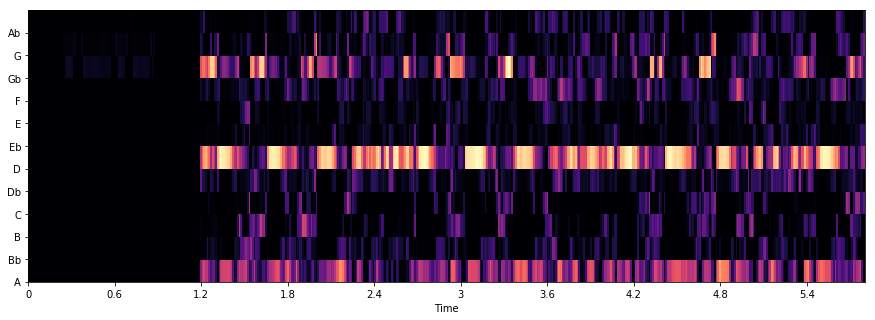

In [5]:
%matplotlib inline
chromagram = chroma_vectors[chord_labels==dataloader._MAJMIN_CLASS_INDEX_MAP['D:maj']][:500, :12].T

fig, ax = plt.subplots(figsize=(15, 5))
specshow(chromagram, x_axis='time', sr=44100)
_ = ax.set_yticks(range(len(chromagram)))
notes = _CHROMA_NOTES_CHORDINO
if len(chromagram) == 24:
    notes += _CHROMA_NOTES_CHORDINO
_ = ax.set_yticklabels(notes)

In [6]:
filt = (chord_labels==dataloader._MAJMIN_CLASS_INDEX_MAP['E:min'])
print(catnp.contiguous_lengths(filt.astype(int)))
print(catnp.squash_consecutive_duplicates(filt.astype(int)))

[2038   41   41   41  235   41  921]
[0 1 0 1 0 1 0]


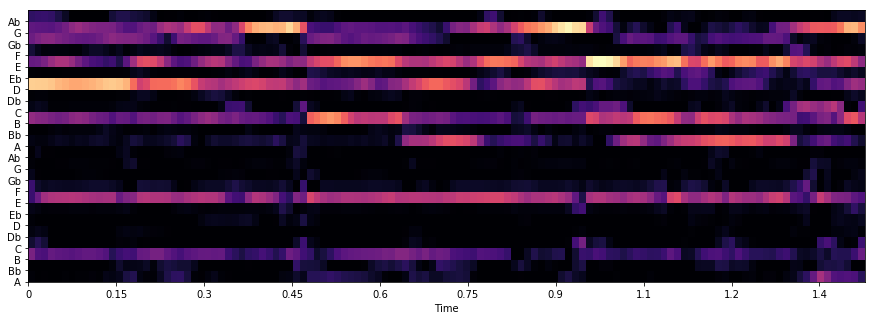

In [14]:
chromagram = chroma_vectors[chord_labels==dataloader._MAJMIN_CLASS_INDEX_MAP['E:min']].T

fig, ax = plt.subplots(figsize=(15, 5))
specshow(chromagram, x_axis='time', sr=44100)
_ = ax.set_yticks(range(len(chromagram)))
notes = _CHROMA_NOTES_CHORDINO
if len(chromagram) == 24:
    notes += _CHROMA_NOTES_CHORDINO
_ = ax.set_yticklabels(notes)

In [51]:
step_size, chroma_timestamps, chroma_vectors = dataloader.get_chroma_matrix(308,
        return_timestamps=True,return_step_size=True)

In [53]:
chroma_timestamps[2417:2420]

array([[112.24526077, 112.29170068],
       [112.29170068, 112.33814059],
       [112.33814059, 112.3845805 ]])

In [54]:
chord_timestamps, chord_labels_str = dataloader.get_chord_labels(_id, label_type='majmin')
chord_labels = dataloader.encode_chords_single_label(chord_labels_str)

In [55]:
chord_timestamps[-5:]

array([[103.2774093 , 104.62465986],
       [104.62465986, 105.97191043],
       [105.97191043, 107.15075468],
       [107.15075468, 107.319161  ],
       [107.319161  , 112.27981859]])

In [27]:
from importlib import reload
reload(dataloader)
import lazycats.np as catnp

chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(308, label_type='majmin',
                                                                        remove_ambiguous=False)

len(chroma_vectors), len(chord_labels)

# now check ff.
# histogram of chroma count before chord changes (i.e. chord duration)
# min & max
# where min and max occurs
# what transition occurs at min/max

(2498, 2498)

In [14]:
df_songs

,id,title,artist,no_chord_percent
0,3,I Don't Mind,James Brown,0.049747
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway",0.050770
2,6,The Rose,Bette Midler,0.117244
3,10,An Innocent Man,Billy Joel,0.029239
4,12,Lookin' For Love,Johnny Lee,0.018727
...,...,...,...,...
714,1286,Sukiyaki,A Taste Of Honey,0.102465
715,1287,Johnny Reb,Johnny Horton,0.010825
716,1289,There She Goes,The La's,0.034247
717,1290,Happy Together,The Turtles,0.026688


In [28]:
from tqdm import tqdm

per_song_chord_dur = []
all_chord_durs = []
for ix in tqdm(df_songs.index):
    _id = df_songs.loc[ix].id
    try:
        chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(_id, label_type='majmin',
                                                                                remove_ambiguous=False)
    except Exception as e:
        print(f'Error {e} at {_id}')
        break
        
    chord_durs = catnp.contiguous_lengths(chord_labels)
    squashed_labels = catnp.squash_consecutive_duplicates(chord_labels)
    n_chords = len(chord_durs)
    assert(n_chords==len(squashed_labels))
    per_song_chord_dur.append(chord_durs)
    all_chord_durs.extend(chord_durs)
    
    min_ix = np.argmin(chord_durs)
    min_dur = chord_durs[min_ix]
    max_ix = np.argmax(chord_durs)
    max_dur = chord_durs[max_ix]
    
    min_trans = (squashed_labels[min_ix], squashed_labels[min_ix+1] if min_ix < (n_chords-1) else -1)
    max_trans = (squashed_labels[max_ix], squashed_labels[max_ix+1] if max_ix < (n_chords-1) else -1)
    
    df_songs.loc[ix, 'n_chords'] = n_chords
    df_songs.loc[ix, 'min_ix'] = min_ix
    df_songs.loc[ix, 'min_dur'] = min_dur
    df_songs.loc[ix, 'max_ix'] = max_ix
    df_songs.loc[ix, 'max_dur'] = max_dur
    df_songs.loc[ix, 'min_trans'] = str(min_trans)
    df_songs.loc[ix, 'max_trans'] = str(max_trans)
    
    #break

 76%|███████▋  | 550/719 [00:28<00:09, 17.15it/s]/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/mir_eval/io.py:281: UserWarning: All interval durations must be strictly positive
  warnings.warn(error.args[0])
100%|██████████| 719/719 [00:37<00:00, 18.98it/s]


In [62]:
df_songs.to_csv(f'{base_dir}/billboard-2.0-manychords-chorddurations.csv', index=False)

In [29]:
all_chord_durs = np.array(all_chord_durs)

In [30]:
from collections import Counter
dur_counts = Counter(all_chord_durs)
dur_counts.most_common()

[(20, 2503),
 (21, 2455),
 (23, 1998),
 (22, 1922),
 (39, 1852),
 (41, 1791),
 (40, 1645),
 (42, 1564),
 (24, 1474),
 (17, 1369),
 (38, 1286),
 (19, 1237),
 (25, 1208),
 (10, 1208),
 (43, 1146),
 (11, 1122),
 (32, 1117),
 (26, 1098),
 (44, 1062),
 (46, 1049),
 (18, 1033),
 (31, 1010),
 (37, 1004),
 (28, 972),
 (45, 949),
 (30, 892),
 (33, 886),
 (29, 872),
 (27, 872),
 (47, 853),
 (35, 847),
 (16, 827),
 (34, 819),
 (36, 735),
 (12, 723),
 (14, 721),
 (15, 710),
 (48, 664),
 (13, 630),
 (53, 605),
 (9, 564),
 (50, 554),
 (56, 517),
 (52, 508),
 (51, 498),
 (57, 488),
 (49, 474),
 (55, 455),
 (61, 447),
 (54, 446),
 (76, 377),
 (58, 373),
 (69, 368),
 (68, 367),
 (66, 330),
 (70, 329),
 (60, 326),
 (82, 321),
 (62, 321),
 (67, 317),
 (80, 314),
 (81, 313),
 (65, 313),
 (8, 308),
 (78, 306),
 (79, 300),
 (83, 297),
 (84, 287),
 (75, 286),
 (77, 286),
 (64, 283),
 (74, 265),
 (63, 249),
 (85, 244),
 (87, 243),
 (59, 241),
 (73, 225),
 (93, 222),
 (92, 202),
 (72, 194),
 (95, 193),
 (88, 1

In [31]:
np.mean(all_chord_durs)

49.50175990970252

Maybe a sequence length of 64/128 makes sense

In [105]:
df_songs.head(n=3)

,id,title,artist,no_chord_percent,min_ix,min_dur,max_ix,max_dur,min_trans,max_trans,n_chords
0,3,I Don't Mind,James Brown,0.049747,43.0,36.0,44.0,124.0,"(22, 0)","(0, -1)",45.0
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway",0.050770,32.0,15.0,25.0,127.0,"(7, 2)","(4, 9)",68.0
2,6,The Rose,Bette Midler,0.117244,38.0,19.0,52.0,333.0,"(8, 1)","(1, 0)",54.0


In [32]:
df_songs.min_dur.mean(), df_songs.max_dur.mean()

(13.9221140472879, 360.3449235048679)

In [33]:
df_songs.min_trans.value_counts()[:10] # most minimum duration start from no-chord

(0, 3)     47
(0, 8)     40
(0, 1)     37
(0, 10)    35
(0, 5)     32
(0, 6)     28
(0, 11)    22
(0, 9)     18
(0, 12)    17
(0, 22)    14
Name: min_trans, dtype: int64

In [34]:
df_songs.max_trans.value_counts()[:10] # most maximum duration is from no-chord to ending

(0, -1)    135
(3, 8)      18
(1, 6)      16
(0, 8)      14
(10, 3)     14
(5, 10)     14
(0, 6)      13
(4, 9)      13
(0, 3)      13
(8, 1)      13
Name: max_trans, dtype: int64

Now, proceed to training a bi-LSTM-CRF w/ sequence length of 64. To do that, we need to prep the data in sequences.

In [ ]:
# prepend zeros in chord labels; need to shift labels by 1; support pre-pad/post-pad
# need to add zeros??? or mean??? in features
# possible lazycats #4

In [1]:
import dataloader
import numpy as np
import lazycats.np as catnp

# per song feature analysis
chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(1289, label_type='majmin')

In [3]:
# to know what value to pad, it might be worth looking at the feats/labels
all_chroma_vectors = np.load('data/01_all_chroma_vectors.npy')
all_chord_labels = np.load('data/01_all_chord_labels.npy')
all_chroma_vectors.shape, all_chord_labels.shape

((3360513, 24), (3360513,))

In [14]:
mean_no_chord_vec = np.mean(all_chroma_vectors[all_chord_labels == 0], axis=0)
mean_no_chord_vec, np.mean(mean_no_chord_vec)

(array([0.32049295, 0.24610202, 0.28693406, 0.25687285, 0.20151652,
        0.29747371, 0.20591433, 0.27151966, 0.22509008, 0.21612551,
        0.26522816, 0.21338926, 0.7405679 , 0.48997662, 0.60600057,
        0.60080249, 0.48543003, 0.73010563, 0.44549839, 0.73231232,
        0.53258909, 0.54258336, 0.6778894 , 0.48055285]), 0.41962365765782206)

In [23]:
from collections import Counter

weak_feat_labels = all_chord_labels[np.all(all_chroma_vectors <= 0.0, axis=1)]
print(len(weak_feat_labels))
Counter(weak_feat_labels)

55118


Counter({0: 49874,
         2: 203,
         8: 537,
         22: 150,
         13: 51,
         6: 464,
         7: 249,
         12: 330,
         9: 192,
         4: 141,
         24: 34,
         1: 399,
         17: 97,
         15: 244,
         10: 434,
         5: 547,
         14: 77,
         3: 414,
         11: 269,
         20: 80,
         18: 140,
         23: 21,
         16: 141,
         19: 29,
         21: 1})

Based on info above, we pad zero vectors for feature subsequences, and zeros for label subsequences (no need to shift the label).

In [9]:
(1,2,*np.array([1]).shape[1:])

(1, 2)

In [11]:
def divide_to_subsequences(seq, sub_len, pad=0, pre_pad=True):
    """
    Divide a sequence array into subsequences across outermost axis,
    padding the last subsequence as needed
    """
    seq = np.array(seq)
    pad = np.array(pad)
    assert(pad.shape == seq.shape[1:])
    
    pad_len = 0
    rem = len(seq)%sub_len
    if rem > 0:
        pad_len = sub_len - rem
        
    n_subseq_nopads = int(len(seq)/sub_len) # num. of subseq. that need no pads
    n_nopads = sub_len*n_subseq_nopads
    subseq = seq[:n_nopads].reshape((n_subseq_nopads, sub_len, *seq.shape[1:]))
    
    if pad_len > 0:
        if pre_pad:
            padded_subseq = np.append(np.array([pad]*pad_len), seq[n_nopads:], axis=0)
        else:
            padded_subseq = np.append(seq[n_nopads:], np.array([pad]*pad_len), axis=0)
            
        subseq = np.append(subseq, padded_subseq[np.newaxis, :], axis=0)
        
    return subseq
    

print(divide_to_subsequences(chord_labels, sub_len=64, pad=0).shape)
print(divide_to_subsequences(chroma_vectors, sub_len=64, pad=[0]*24).shape)

(53, 64)
(53, 64, 24)


In [12]:
print(divide_to_subsequences(np.array([1,1,1,1,2,2,2,2,3,3,3]), sub_len=8, pad=0))
print(divide_to_subsequences(np.array([1,1,1,1,2,2,2,2,3,3,3]), sub_len=8, pad=0, pre_pad=False))

[[1 1 1 1 2 2 2 2]
 [0 0 0 0 0 3 3 3]]
[[1 1 1 1 2 2 2 2]
 [3 3 3 0 0 0 0 0]]


In [1]:
# create dataset
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-manychords.csv'

df_songs = pd.read_csv(f'{base_dir}/{data_index}')
df_songs.set_index('id', inplace=True)
len(df_songs)

719

In [2]:
df_songs.head(n=3)

,title,artist,no_chord_percent
id,,,
3,I Don't Mind,James Brown,0.049747
4,You've Got A Friend,"Roberta Flack,Donny Hathaway",0.050770
6,The Rose,Bette Midler,0.117244


In [3]:
# pre-generate sequences
import os
import pickle
import joblib
from tqdm import tqdm

import lazycats.np as catnp
import dataloader

_DUMP_DIR = 'data/chordseq'
_LABEL_TYPE = 'majmin'
_SEQ_LEN = 128 #64 #32
_CHROMA_NUM_FEATS = 24

os.makedirs(_DUMP_DIR, exist_ok=True)

chordseq_dict = {}

for _id in tqdm(df_songs.index):
    chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(_id, label_type=_LABEL_TYPE)
    assert(chroma_vectors.shape[-1] == _CHROMA_NUM_FEATS)
    
    chordseq_vectors = catnp.divide_to_subsequences(chroma_vectors, sub_len=_SEQ_LEN)
    chordseq_labels = catnp.divide_to_subsequences(chord_labels, sub_len=_SEQ_LEN)
    
    chordseq_dict[_id] = {'feats': chordseq_vectors, 'labels': chordseq_labels}
    
    #break
    
#joblib.dump(chordseq_dict, f'{_DUMP_DIR}/{_LABEL_TYPE}_{_SEQ_LEN}.pkl')
with open(f'{_DUMP_DIR}/{_LABEL_TYPE}_{_SEQ_LEN}.pkl', 'wb') as f:
    pickle.dump(chordseq_dict, f)

 77%|███████▋  | 551/719 [00:26<00:07, 21.11it/s]/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/mir_eval/io.py:281: UserWarning: All interval durations must be strictly positive
  warnings.warn(error.args[0])
100%|██████████| 719/719 [00:34<00:00, 20.74it/s]


In [28]:
len(chordseq_dict)

719

#### Slicing (not used)

In [27]:
from itertools import islice
dict(islice(b.items(), 1, 3))

{5: 6}

In [30]:
import joblib # lazycats.py
from itertools import islice

dump_dict = {}
dump_ix = 0
_DUMP_SIZE = 100

st = 0
ed = _DUMP_SIZE
while st < len(chordseq_dict):    
    dump_dict = dict(islice(chordseq_dict.items(), st, ed))
    joblib.dump(dump_dict, f'{_DUMP_DIR}/{_LABEL_TYPE}_{_SEQ_LEN}_{dump_ix}.pkl')
    
    dump_ix += 1
    st = dump_ix*_DUMP_SIZE
    ed = st+_DUMP_SIZE

In [32]:
# read
load_ix = 0
loaded_dict = {}
while True:
    fn = f'{_DUMP_DIR}/{_LABEL_TYPE}_{_SEQ_LEN}_{load_ix}.pkl'
    if not os.path.exists(fn):
        break

    loaded_dict.update(joblib.load(fn))
    load_ix += 1

In [44]:
for k1, k2 in zip(chordseq_dict, loaded_dict):
    assert(k1==k2)
    assert(chordseq_dict[k1]==chordseq_dict[k2])
    break

In [54]:
# with open(f'{_DUMP_DIR}/{_LABEL_TYPE}_{_SEQ_LEN}.pkl', 'rb') as f:
#     c = pickle.load(f)

#### Onset/Tempo exploration

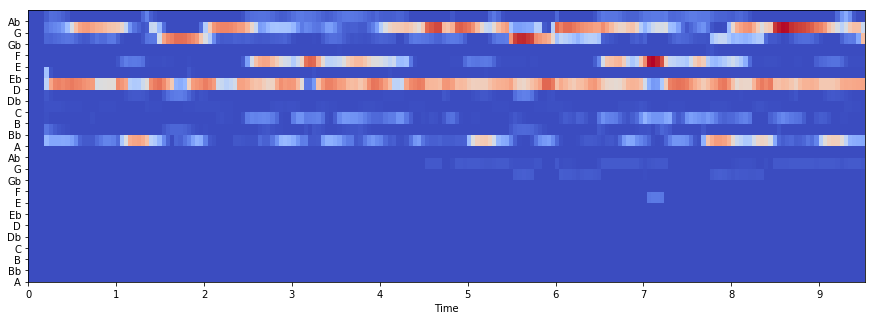

In [7]:
# visualize song first
chromagram = chroma_vectors[:200].T
#print(chord_labels[:200])

fig, ax = plt.subplots(figsize=(15, 5))
# xcoords = [0.22058956, 0.33088437, 2.20589566]
# for xc in xcoords:
#     plt.axvline(x=xc, color='black')

specshow(chromagram, x_axis='time', sr=21, hop_length=1, cmap='coolwarm') # wrong SR
_ = ax.set_yticks(range(len(chromagram)))
notes = _CHROMA_NOTES_CHORDINO
if len(chromagram) == 24:
    notes += _CHROMA_NOTES_CHORDINO
_ = ax.set_yticklabels(notes)

In [75]:
help(specshow)

Help on function specshow in module librosa.display:

specshow(data, x_coords=None, y_coords=None, x_axis=None, y_axis=None, sr=22050, hop_length=512, fmin=None, fmax=None, tuning=0.0, bins_per_octave=12, key='C:maj', Sa=None, mela=None, thaat=None, ax=None, **kwargs)
    Display a spectrogram/chromagram/cqt/etc.
    
    For a detailed overview of this function, see :ref:`sphx_glr_auto_examples_plot_display.py`
    
    Parameters
    ----------
    data : np.ndarray [shape=(d, n)]
        Matrix to display (e.g., spectrogram)
    
    sr : number > 0 [scalar]
        Sample rate used to determine time scale in x-axis.
    
    hop_length : int > 0 [scalar]
        Hop length, also used to determine time scale in x-axis
    
    x_axis, y_axis : None or str
        Range for the x- and y-axes.
    
        Valid types are:
    
        - None, 'none', or 'off' : no axis decoration is displayed.
    
        Frequency types:
    
        - 'linear', 'fft', 'hz' : frequency range is det

In [16]:
# check if echonest might help
import json
def get_echonest_features(_id):
    """ Load chord labels from .LAB files
    
    label_type: majmin, majmin7, majmininv, majmin7inv, full
    """
    feat_fn = f'{base_dir}/{_id:04d}/echonest.json'
    feats = {}
    with open(feat_fn, 'r') as f:
        feats = json.loads(f.read())
        
    return feats

In [16]:
feats = get_echonest_features(1289)

In [25]:
feats.keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'tatums', 'sections', 'segments'])

In [29]:
for k in feats:
    print(len(feats[k]), type(feats[k]))

13 <class 'dict'>
25 <class 'dict'>
80 <class 'list'>
324 <class 'list'>
648 <class 'list'>
10 <class 'list'>
532 <class 'list'>


In [37]:
print(feats['bars'][0])
print(feats['beats'][0])
print(feats['tatums'][0])
print(feats['sections'][0])
print(feats['segments'][0])

{'start': 0.63328, 'duration': 2.01045, 'confidence': 0.021}
{'start': 0.63328, 'duration': 0.50757, 'confidence': 0.948}
{'start': 0.63328, 'duration': 0.25378, 'confidence': 0.948}
{'start': 0.0, 'duration': 16.6403, 'confidence': 1.0}
{'start': 0.0, 'duration': 0.59778, 'confidence': 1.0, 'loudness_start': -60.0, 'loudness_max_time': 0.41521, 'loudness_max': -12.94, 'pitches': [0.167, 0.176, 1.0, 0.246, 0.19, 0.058, 0.163, 0.089, 0.095, 0.225, 0.077, 0.066], 'timbre': [9.347, 167.408, 132.918, -269.875, 43.911, -112.505, 50.196, -81.25, -28.616, 24.392, 169.291, -37.882]}


In [42]:
print(feats['meta'])
print({k:feats['track'][k] for k in feats['track'] if 'string' not in k})

{'analyzer_version': '3.1.4', 'detailed_status': 'OK', 'filename': '/tmp/tmpJ4Ag6a/06fc6d1c5eda667cdb05a5db7f539fce.mp4', 'artist': "The La's", 'album': 'THE BRIT BOX [Disc1]', 'title': 'There She Goes', 'genre': 'Alternative', 'bitrate': 320, 'sample_rate': 44100, 'seconds': 162, 'status_code': 0, 'timestamp': 1375659217, 'analysis_time': 2.15302}
{'num_samples': 3585014, 'duration': 162.58567, 'sample_md5': 'feca967a8f65bcb81f51eb8d8a325b23', 'decoder': 'ffmpeg', 'offset_seconds': 0, 'window_seconds': 0, 'analysis_sample_rate': 22050, 'analysis_channels': 1, 'end_of_fade_in': 0.0, 'start_of_fade_out': 153.7161, 'loudness': -5.367, 'tempo': 122.613, 'tempo_confidence': 0.912, 'time_signature': 4, 'time_signature_confidence': 1.0, 'key': 7, 'key_confidence': 0.936, 'mode': 1, 'mode_confidence': 0.821, 'code_version': 3.15, 'echoprint_version': 4.12, 'synch_version': 1.0}


We can use tempo and time signature here. However it seems the Echonest is not open-source anymore; hence we use these values simply as reference for the tempo estimation method we'll find/implement.

In [17]:
import librosa

def estimate_tempo(_id):
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    onset_env = librosa.onset.onset_strength(X, sr=fs)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=fs)
    return tempo

estimate_tempo(1289)

array([123.046875])

In [20]:
picked_ids = [1289, 736, 637, 270, 18] # those w/ audio
for _id in picked_ids:
    feats = get_echonest_features(_id)
    print(f"Echonest: {feats['track']['tempo']:.2f} ({feats['track']['tempo_confidence']:.2f})"
          f", Librosa: {estimate_tempo(_id)[0]:.2f}")

Echonest: 122.61 (0.91), Librosa: 123.05
Echonest: 113.30 (1.00), Librosa: 112.35
Echonest: 93.18 (0.80), Librosa: 93.96
Echonest: 104.24 (0.85), Librosa: 105.47
Echonest: 121.67 (0.98), Librosa: 123.05


In [23]:
audio_fn = f'data/audio/1289/audio.wav'
X, fs = librosa.load(audio_fn, sr=None, mono=True)
onset_env = librosa.onset.onset_strength(X, sr=fs)

In [50]:
chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(637, label_type='majmin')
onset_env = librosa.onset.onset_strength(np.mean(chroma_vectors, axis=1), sr=2048)
librosa.beat.tempo(onset_envelope=onset_env, sr=2048)

array([120.])

In [34]:
np.mean(chroma_vectors, axis=1).shape

(3358,)

#### Scratch

In [8]:
!head {dirname}/bothchroma.csv

"/tmp/audio.wav",0.000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.046439909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.092879818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.139319727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.185759637,0,0,0,0,0,0,0,0,0,0,0,0,1.18229,0.415419,0.0468095,0.0618448,0.11878,1.71171,1.36705,0,0,0.272477,0.413524,0.179756
,0.232199546,0,0,0,0,0,0,0,0,0,0,0,0,0.975941,0.281009,0,0.0580218,0.0350331,3.12712,0.0937747,0,0,0.253713,0.529589,0.344651
,0.278639455,0,0,0,0,0,0,0,0,0,0,0,0,0.974944,0.165675,0,0.0555288,0,3.45902,0,0.00108475,0,0.299161,0.61126,0.333003
,0.325079365,0,0,0,0,0,0,0,0,0,0,0,0,0.984482,0.0991922,0,0.0518706,0,3.51712,0,0.00408833,0,0.332985,0.669024,0.297315
,0.371519274,0,0,0,0,0,0,0,0,0,0,0,0,1.01016,0.0540823,0,0.0449413,0,3.45042,0,0.00715798,0,0.386501,0.861106,0.214237
,0.417959183,0,0,0,0,0,0,0,0,0,0,0,0,0.980642,0.0275225,0,0.0331996,0,3.5245,0,0.0118653,0,0.415727,1.31184,0.134995


In [20]:
dirname

'data/McGill-Billboard/1289'